In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

# 1. Open exploration

In this file an open exploration has been carried out, in order to explore the given dike model. The open exploration explores two runs of the model; one run without policies and one run with 100 random policies applied. This file will apply multiple exploratory techniques to the outcomes of both runs. The following methods will be covered:

- Multi scatter plots
- Feature scoring - ja
- Dimensional stacking - ja
- Scenario discovery (using PRIM)
- Global sensitivity analysis (using SOBOL)

In [2]:
# Retrieve data from the csv files and merge the files to create a combined datafile

outcomes_0 = pd.read_csv('data/output_data/outcomes_20000s_0p.csv')
outcomes_random = pd.read_csv('data/output_data/outcomes_20000s_100p_random.csv')
# Merge files and save dataframe to seperate csv file
outcomes_combined = pd.concat([outcomes_0, outcomes_random])
outcomes_combined.to_csv('data/output_data/outcomes_20000_0p+100p_random.csv')

experiments_0 = pd.read_csv('data/output_data/experiments_20000s_0p.csv')
experiments_random = pd.read_csv('data/output_data/experiments_20000s_100p_random.csv')
# Merge files and save to seperate csv file
experiments_combined = pd.concat([experiments_0, experiments_random])
experiments_combined.to_csv('data/output_data/experiments_20000_0p+100p_random.csv')


In [4]:
outcomes_random

Unnamed: 0  Expected Annual Damage  Dike Investment Costs   
0             0            4.166021e+09                      0  \
1             1            2.631619e+08                      0   
2             2            3.290590e+08                      0   
3             3            2.789307e+09                      0   
4             4            4.922192e+08                      0   
..          ...                     ...                    ...   
995         995            2.958064e+08                      0   
996         996            4.773612e+07                      0   
997         997            1.609492e+08                      0   
998         998            1.482244e+09                      0   
999         999            2.101714e+09                      0   

     RfR Investment Costs  Evacuation Costs  Expected Number of Deaths   
0                     0.0               0.0                   4.848240  \
1                     0.0               0.0                   0.262102   
2                     0.0               0.0                   0.588471   
3                     0.0               0.0                   1.845089   
4                     0.0               0.0                   0.585487   
..                    ...               ...                        ...   
995                   0.0               0.0                   0.296392   
996                   0.0               0.0                   0.074075   
997                   0.0               0.0                   0.219944   
998                   0.0               0.0                   1.288882   
999                   0.0               0.0                   1.777530   

       policy  
0    policy 0  
1    policy 0  
2    policy 0  
3    policy 0  
4    policy 0  
..        ...  
995  policy 0  
996  policy 0  
997  policy 0  
998  policy 0  
999  policy 0  

[1000 rows x 7 columns]

In [76]:
# Drop the unnamed column, not relevant for the analysis
experiments_combined = experiments_combined.drop(columns='Unnamed: 0')
outcomes_combined = outcomes_combined.drop(columns='Unnamed: 0')
experiments_random =  experiments_random.drop(columns='Unnamed: 0')
outcomes_random = outcomes_random.drop(columns='Unnamed: 0')
experiments_0 = experiments_0.drop(columns='Unnamed: 0')
outcomes_0 = outcomes_0.drop(columns='Unnamed: 0')

# 1.1 Multiscatter plot

Below the multi scatter plots are shown, which provides visual insight in the potential relationships between the model outcomes. Three different multi scatter plots will be presented:

   - 1.1.1 Multi scatter plot for model run with 0 policies (zero policy)
   - 1.1.2 Multi scatter plot for model run with 100 random policies
   - 1.1.3 Multi scatter plot for model run with both the zero and random policies)

## 1.1.1 Multi scatter plot for model run with 0 policies (zero policy)

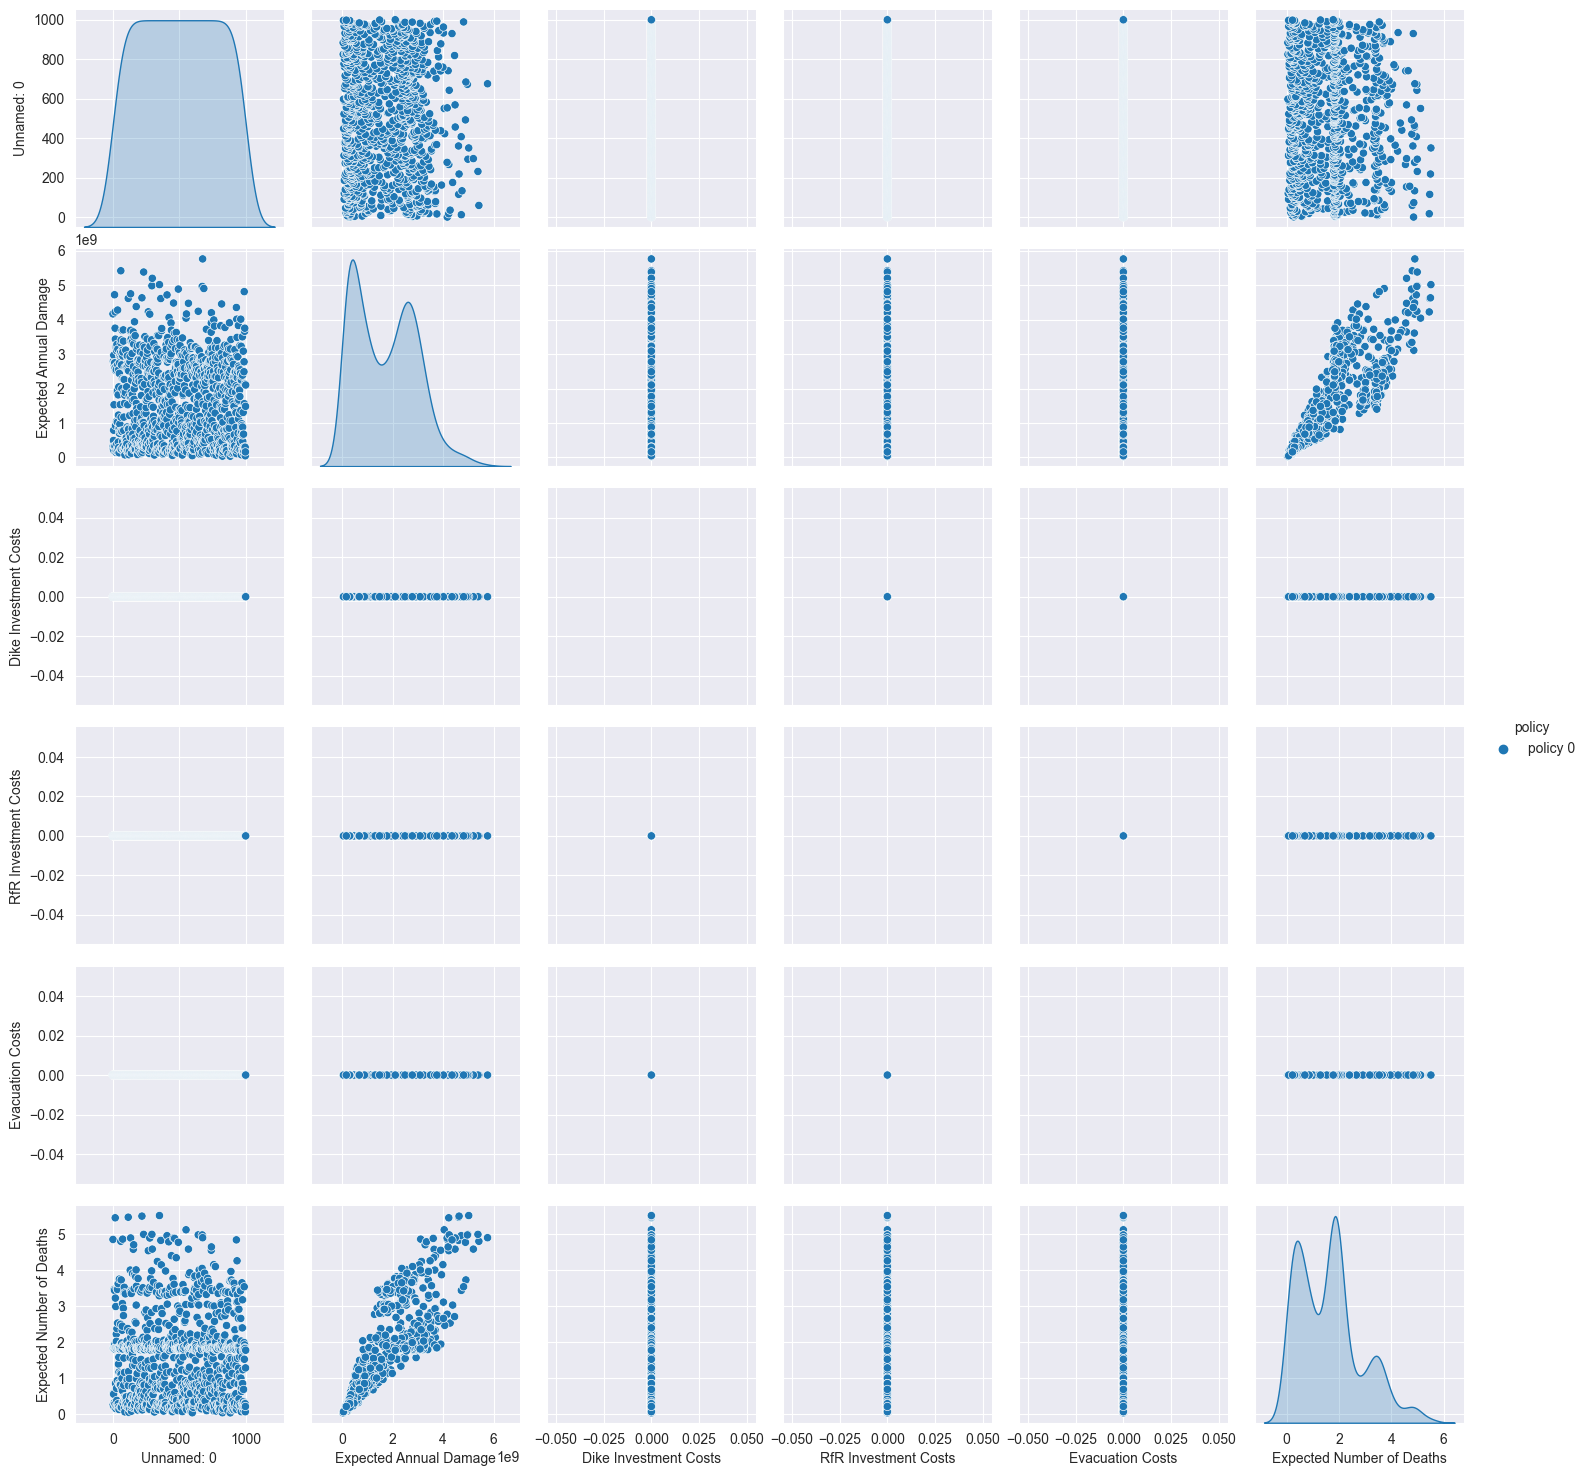

In [86]:
sns.pairplot(outcomes_0, hue='policy')
plt.show()

The multi scatter plot shows that there seems to exist a positive correlation between the expected number of deaths and the expected actual damage. It implies that the higher the annual damage, the higher the number of deaths will be. All other outcomes logically shows a zero value in the plot, due to the fact that no policies were applied.

## 1.1.2 Multi scatter plot for model run with 100 random policies

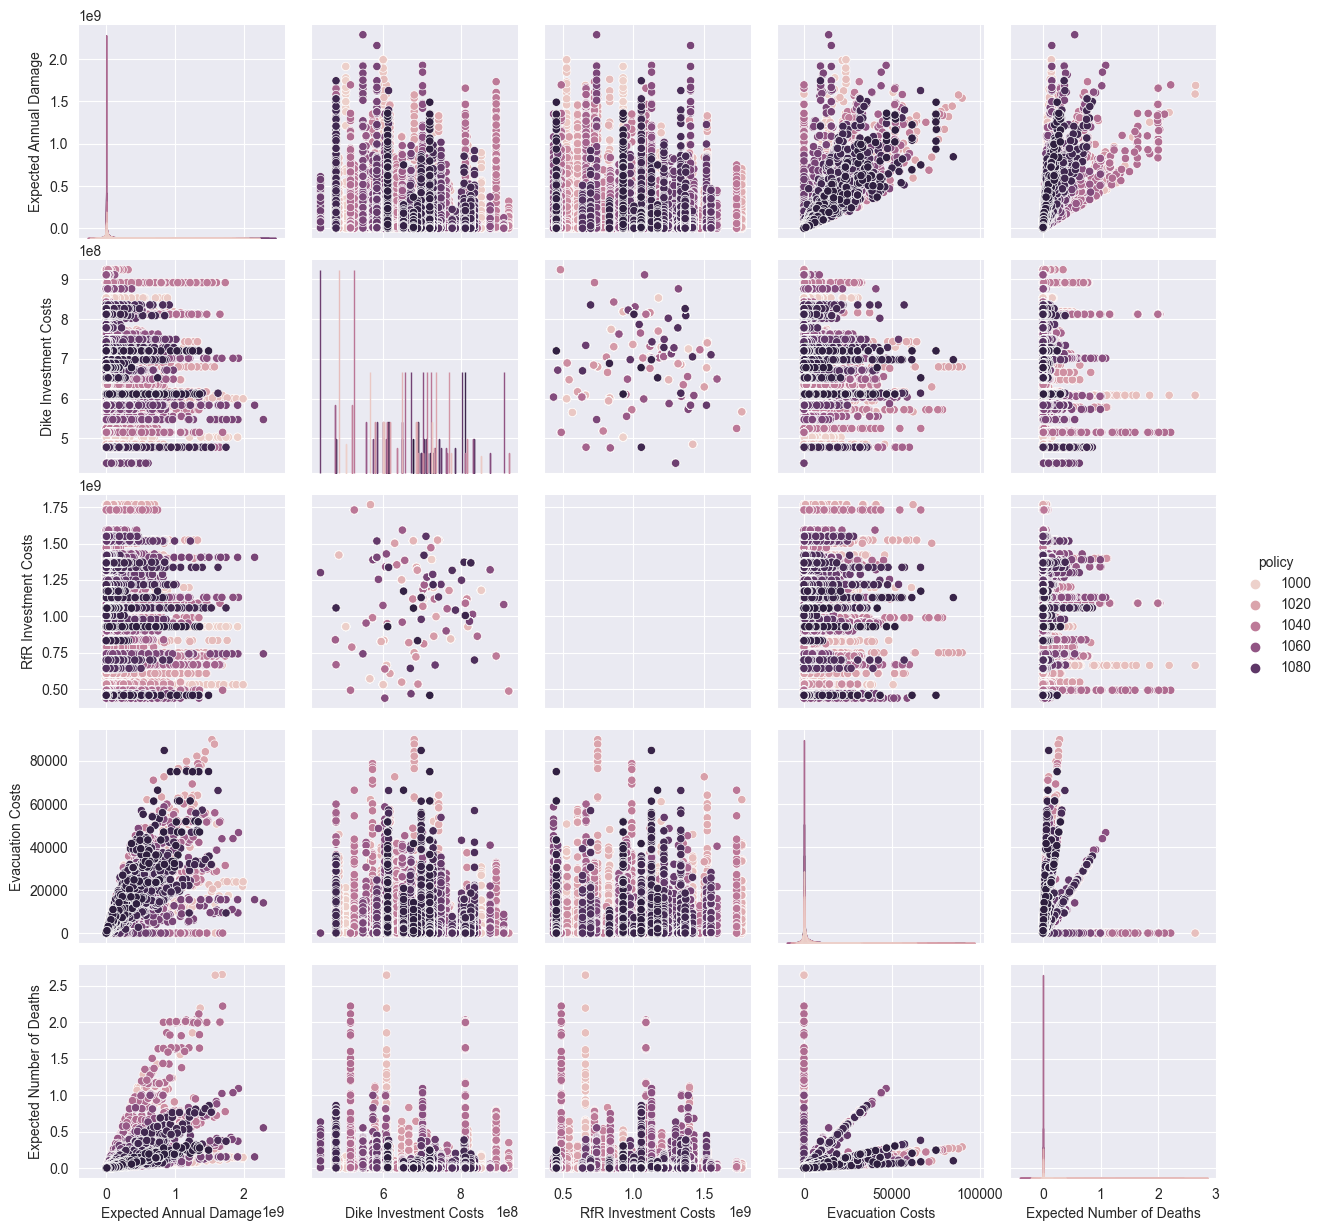

In [8]:
sns.pairplot(outcomes_random, hue='policy')
plt.show()

explanation balala

## 1.1.3 Multi scatter plot for model run with both the zero and random policies

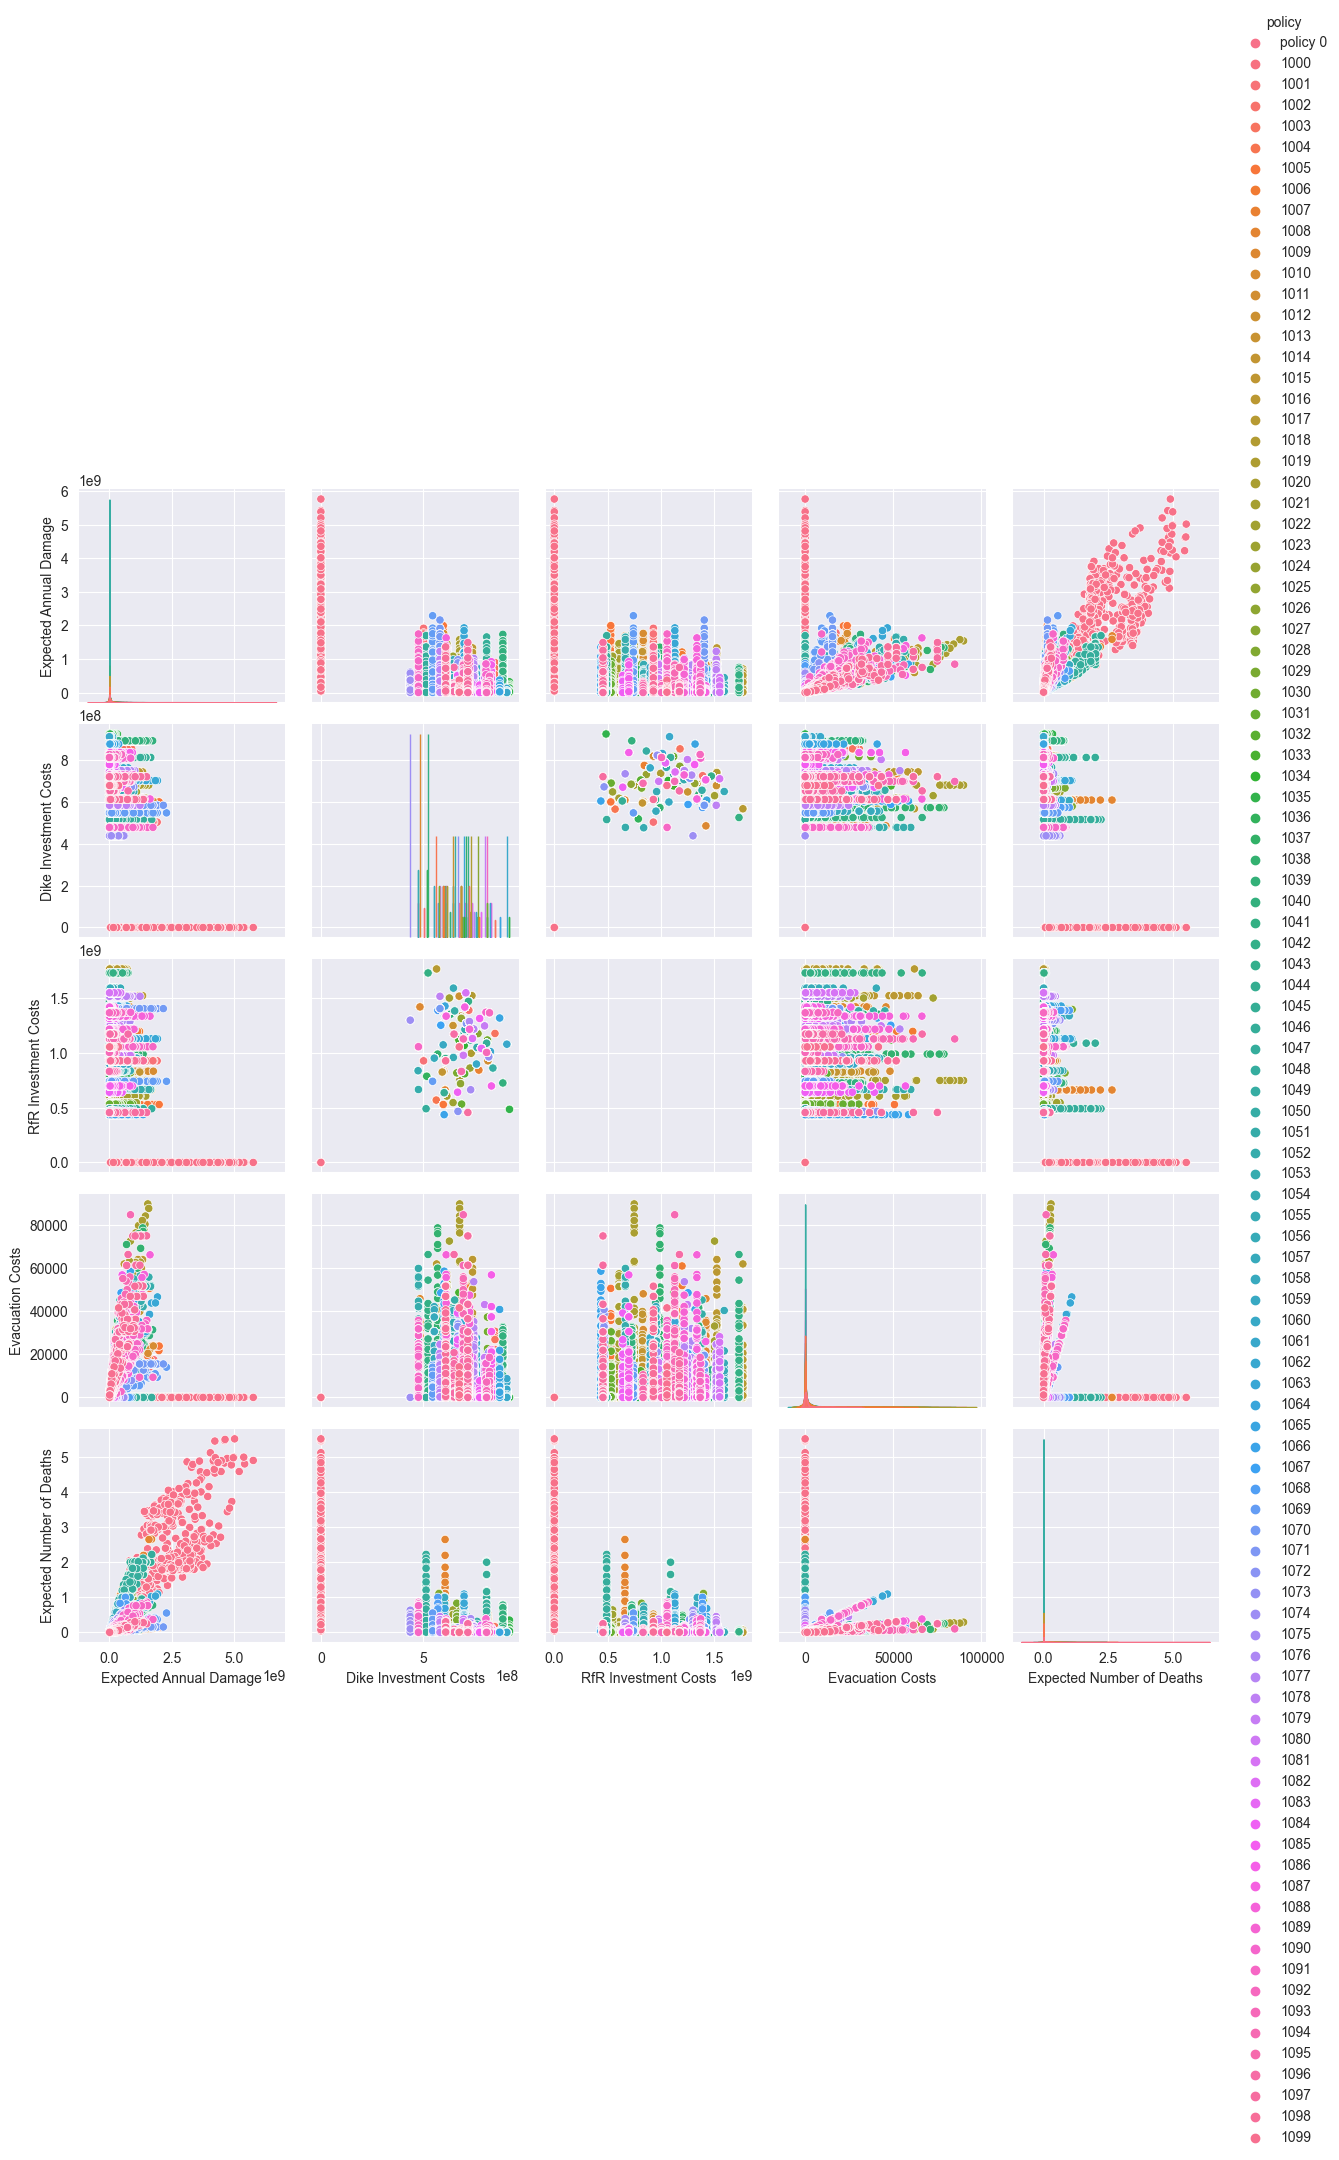

In [9]:
sns.pairplot(outcomes_combined, hue='policy')
plt.show()

balalal

# 2. Scenario discovery

The scenario discovery consists of three different techniques: feature scoring, dimensional stacking and PRIM.

   - Feature scoring: feature scoring is used to explore how, and to what extent the uncertainties influence the model outcomes
   - Dimensional stacking: dimensional stacking is used to identify which uncertainties have the most important influence to the model behaviour
   - PRIM: PRIM is used to identify CHECKEN!

These techniques will seperately be applied to the two model runs. For the sake of clarity, the results of all applied techniques will be shown consecutively, per model run. First, the results for the zero policy are shown after which the application to the model with 100 random policies is presented.

In [11]:
# A list has been created of uncertainties in the model
list_of_uncertainties = ['discount rate 0','discount rate 1','discount rate 2',\
'A.0_ID flood wave shape',
'A.1_Bmax','A.1_pfail','A.1_Brate',\
'A.2_Bmax','A.2_pfail','A.2_Brate',\
'A.3_Bmax','A.3_pfail','A.3_Brate',\
'A.4_Bmax','A.4_pfail','A.4_Brate',\
'A.5_Bmax','A.5_pfail','A.5_Brate',]

uncertainty_experiments_0 = experiments_0.loc[:,list_of_uncertainties]
uncertainty_experiments_random = experiments_random.loc[:,list_of_uncertainties]

## 2.1 Scenaro discovery zero policy
### 2.1.1 Feature scoring

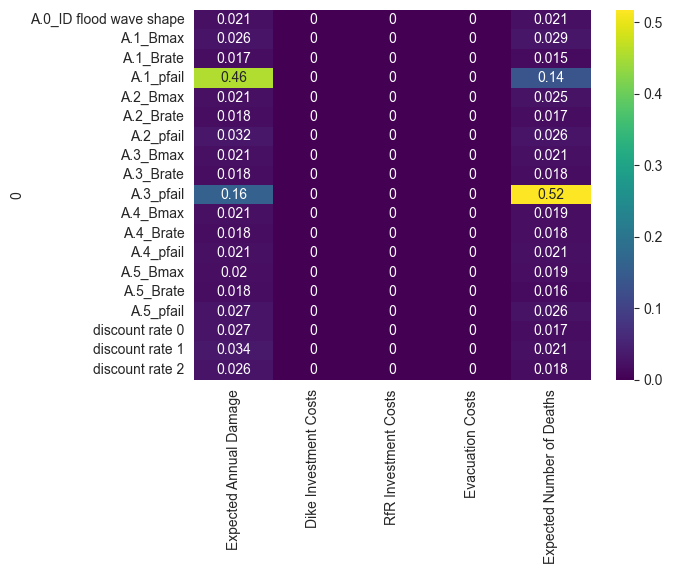

In [13]:
# Plotting and calculating the feature scoring for each uncertainty and all outcomes
fs = feature_scoring.get_feature_scores_all(uncertainty_experiments_0, outcomes_0.drop(columns='policy'))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

The feature scoring for the zero policy shows that primarily the pfail of dike ring A1 and A3 affects the expected number of death and annual damages. It can be seen that the expected annual damages is mostly influenced by the chance that the dike fails at dike ring A1, while the chance that the dike of A3 fails mainly influences the expected number of deaths.

## 2.1.2 PRIM

Below PRIM has been used for the zero policy. It is chosen to focus at the 10% worst outcomes for both the number of expected deaths and the expected annual damage. This means that only 10% of all scenarios with either the highest number of expected deaths or the highest expected annual damage are included.

The PRIM algorithm was used with the default value for the peeling alfa and a value of 0.8 as threshold. 0.8 was chosen after conducting a small sensitivty analysis, which showed that the use of another threshold did not lead to significantly different results


Wel nog iets toevoegen over keuze van box!!
### 2.1.2.1 Expected Number of Deaths

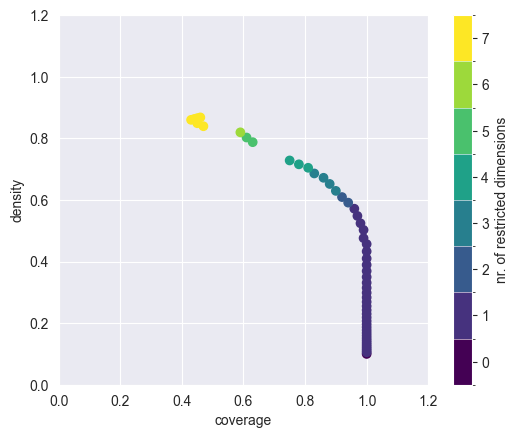

In [15]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
x = uncertainty_experiments_0
y = outcomes_0['Expected Number of Deaths'] > np.percentile(outcomes_0['Expected Number of Deaths'],90) #

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
#NOG BEPALEN WELKE BOX WE WILLEN BEKIJKEN!
box1.inspect(40)
box1.inspect(40, style="graph")
box1.show_pairs_scatter(40)
plt.show()

### 2.1.2.2 Expected Annual Damage

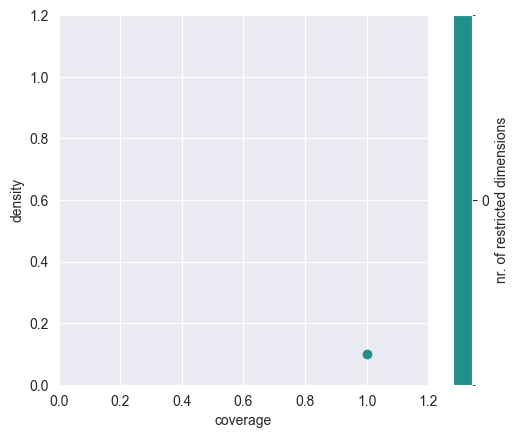

In [16]:
# applying PRIM to the 10% worst outcomes for the expected annual damage (highest annual damage costs)
x = uncertainty_experiments_0
y = outcomes_0['Expected Annual Damage'] > np.percentile(outcomes_0['Expected Annual Damage'],90) #

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
#NOG BEPALEN WELKE BOX WE WILLEN BEKIJKEN!
box1.inspect(0)
box1.inspect(0, style="graph")
box1.show_pairs_scatter(0)
plt.show()

## 2.1.3 Dimensional stacking

The same logic as for the PRIM technique has been used to focus on the 10% worst outcomes for the dimensional stacking
### 2.1.3.1 Expected Number of Deaths

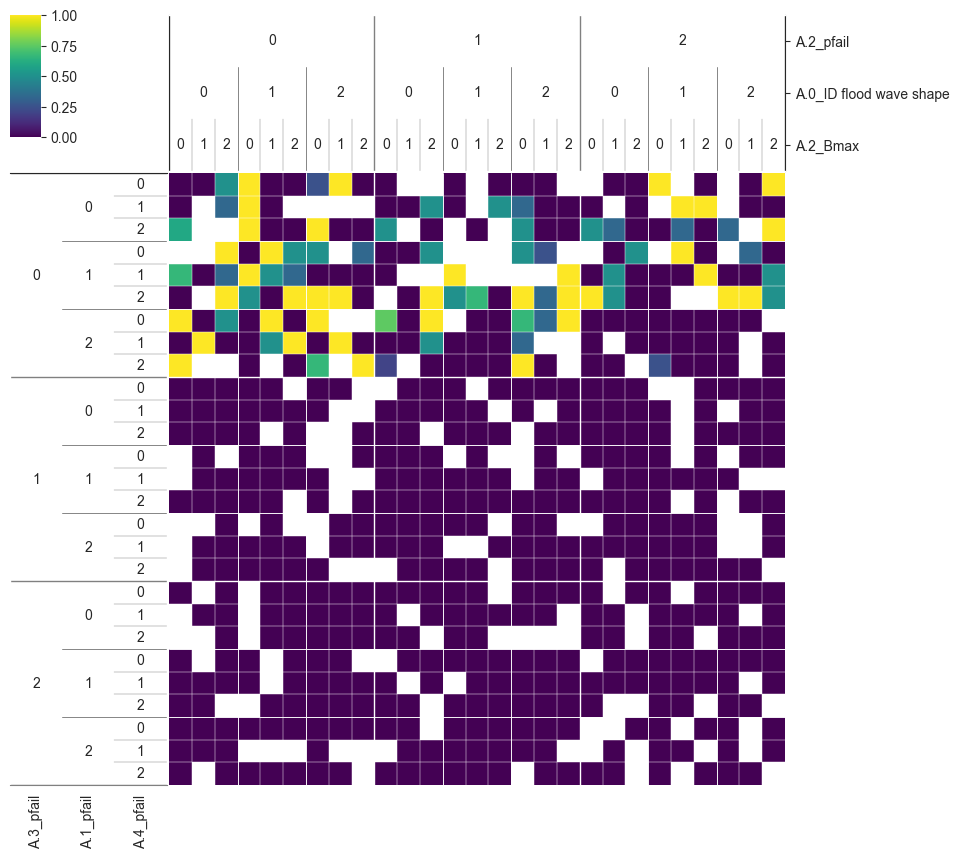

In [17]:
x = uncertainty_experiments_0
y = outcomes_0['Expected Number of Deaths'].values > np.percentile(outcomes_0['Expected Number of Deaths'],90)
dimensional_stacking.create_pivot_plot(x,y)
plt.show()

It can be seen that the fail chances of the dikes of dike rings A1 and A3 are identified as the most important uncertainties for the system behaviour of the dike model, regarding the expected number of deaths. Also, the B-max of those dike rings has been analysed as important and influential. It thus appears that the uncertainties of especially dike ring 1 and 2 have high influence to the expected number of deaths.

It should be noted that the model did not run enough scenarios, as can be seen by the amount of black bins. However, due to time constraints, it is chosen not to increase the amount scenarios for now

### 2.1.3.2 Expected Annual Damage

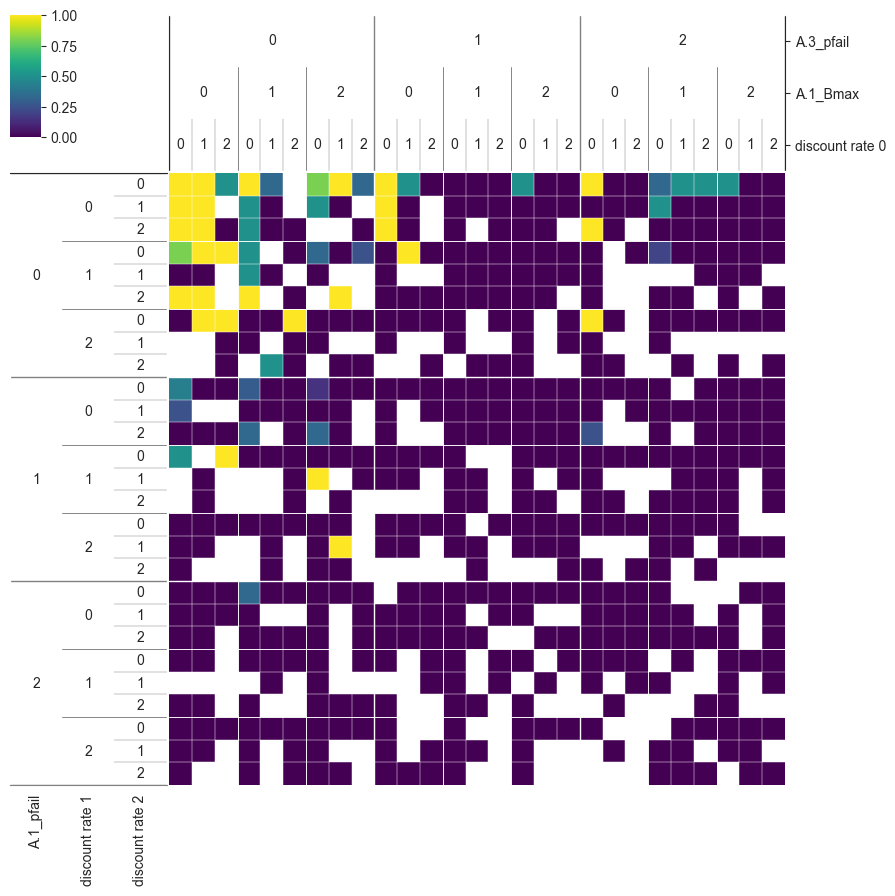

In [18]:
x = uncertainty_experiments_0
y = outcomes_0['Expected Annual Damage'].values > np.percentile(outcomes_0['Expected Annual Damage'],90)
dimensional_stacking.create_pivot_plot(x,y)
plt.show()

The same conclusion as for the number of expected deaths can be drawn for the expected annual damage; the fail chances of the dikes in dike rings A1 and A3 have high influence to the annual damage. It can also be seen that the discount rates are of high importance. This makes sense due to the fact that the expected annual damage is being monitized over time by the discount rate; the value of the discount rate therefore influences the magnitude of the expected costs. This is reflected in the results.

It should be noted that the model did not run enough scenarios, as can be seen by the amount of black bins. However, due to time constraints, it is chosen not to increase the amount scenarios for now

## 2.2 Scenaro discovery 100 random policies
### 2.2.1 Feature scoring

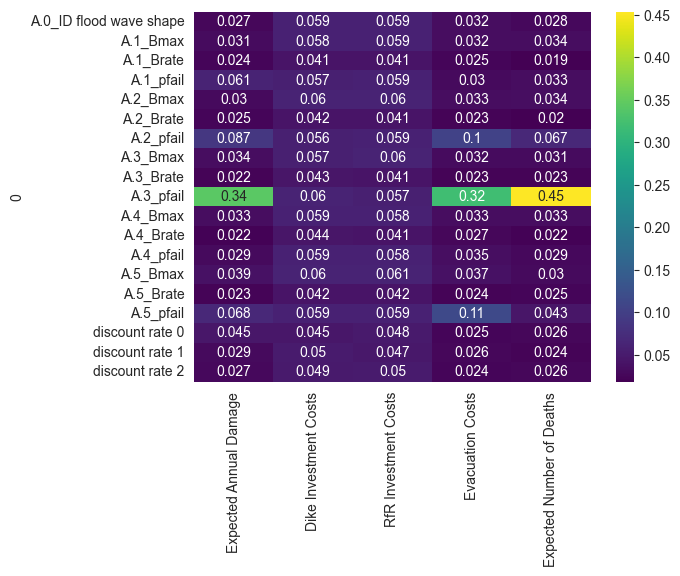

In [21]:
# Plotting and calculating the feature scoring for each uncertainty and all outcomes
fs = feature_scoring.get_feature_scores_all(uncertainty_experiments_random,outcomes_random.drop(columns='policy'))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

The feature scoring shows that for 100 random policies the model outcomes are mainly influenced by the pfail of A3. It can be seen that the chance of failing for the dike in A3 will have the highest impact to the expected annual damage, the evacuation costs and especially the number of deaths.

## 2.2.2 PRIM

The application of PRIM to the model run with 100 random policies uses a different focus then the zero policy model run. In this case, it is chosen not to look at the 10% worst outcomes, but to apply a threshold in order to focus on desired outcomes. The threshold for the number of expected deaths has been set to 0.001 and the expected annual damage has been set 10e08
### 2.1.2.1 Expected Number of Deaths

[MainProcess/INFO] 100000 points remaining, containing 47898 cases of interest
[MainProcess/INFO] mean: 0.8472549019607843, mass: 0.051, coverage: 0.09021253497014489, density: 0.8472549019607843 restricted_dimensions: 6


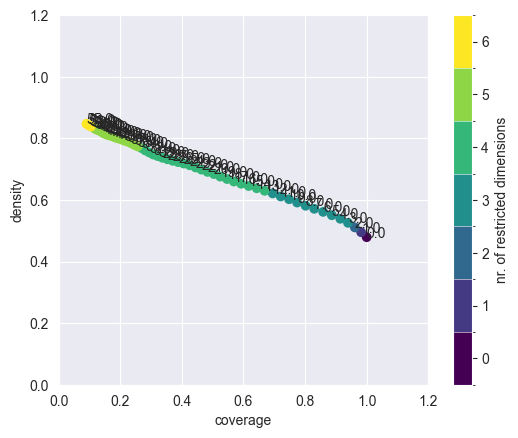

In [69]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
x = uncertainty_experiments_random
y = outcomes_random['Expected Number of Deaths'] < 0.001

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff(annotated=True)
plt.show()

coverage     0.190467
density      0.800263
id          41.000000
mass         0.114000
mean         0.800263
res_dim      5.000000
Name: 41, dtype: float64

             box 41                                  
                min       max       qp value qp value
A.3_pfail  0.441174  0.999640  5.046100e-209      NaN
A.5_pfail  0.512496  0.999129  6.870372e-195      NaN
A.2_pfail  0.435690  0.999474  1.635311e-125      NaN
A.4_pfail  0.205263  0.999340   7.297982e-16      NaN
A.1_pfail  0.070895  0.999843   1.077847e-01      NaN



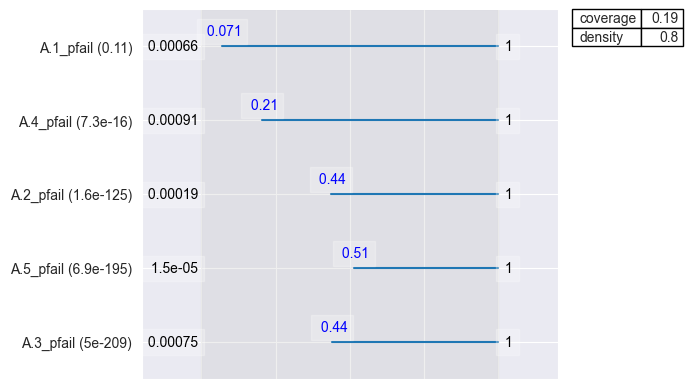

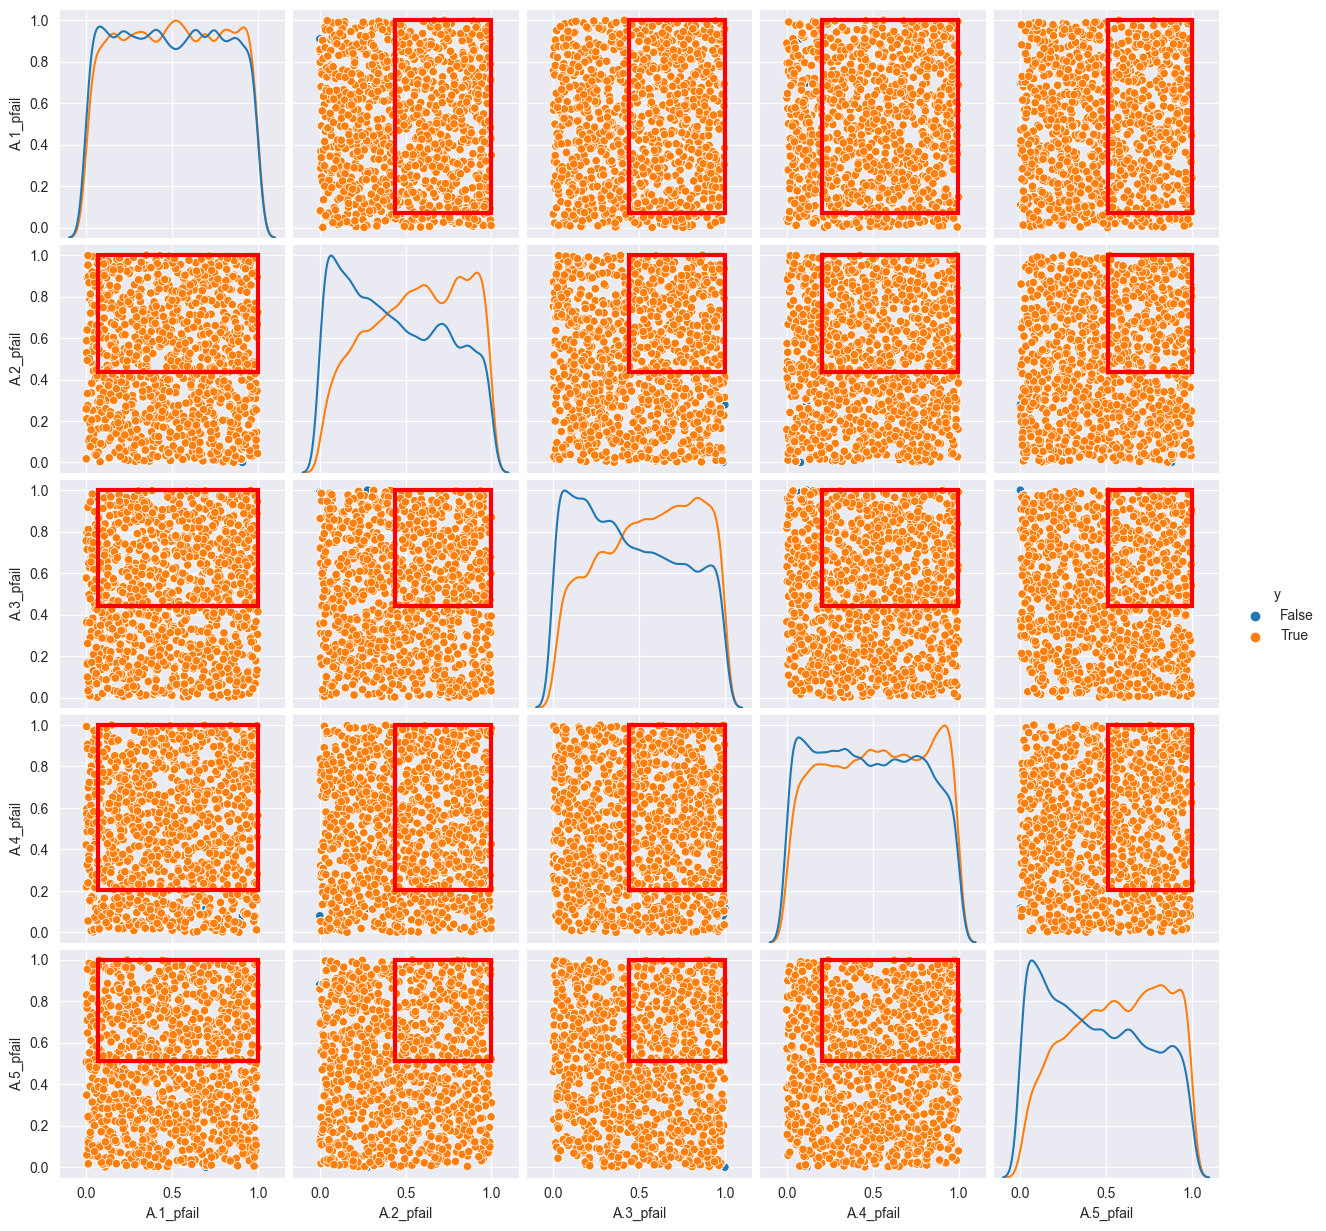

In [43]:
#NOG BEPALEN WELKE BOX WE WILLEN BEKIJKEN!
box1.inspect(41)
box1.inspect(41, style="graph")
box1.show_pairs_scatter(41)
plt.show()

### 2.1.2.2 Expected annual damage

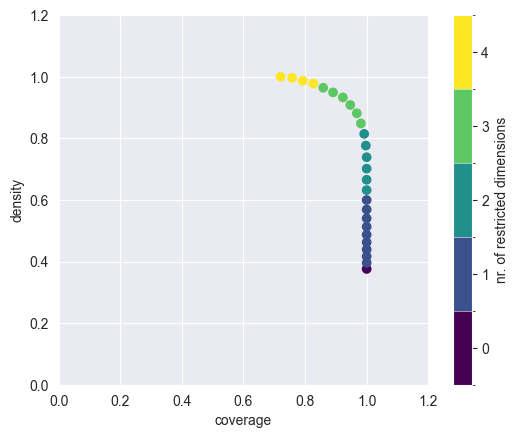

In [35]:
# applying PRIM to the 10% worst outcomes for the expected annual damage (highest annual damage costs)
x = uncertainty_experiments_0
y = outcomes_0['Expected Annual Damage'] < 10e08
prim_alg = prim.Prim(x, y, threshold=0.4)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

2.2.3 Dimensional stacking


# 1.3 Global sensitivity analysis (SOBOL)


In [61]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import Samplers
from ema_workbench.em_framework import get_SALib_problem
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
from SALib.analyze.sobol import analyze
from SALib.analyze import sobol

In [50]:
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [51]:
problem = get_SALib_problem(dike_model.uncertainties)
problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [52]:
experiments = pd.read_csv('data/output_data/sobol_open_exploration_1000s_experiments.csv', index_col=None)
results = pd.read_csv('data/output_data/sobol_open_exploration_1000s_results.csv', index_col=None)
print(f"Shape of data: {experiments.shape[0]} rows, {experiments.shape[1]} columns.")
experiments.head(10)

Shape of data: 40960 rows, 54 columns.


Unnamed: 0  A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail   
0           0                       64  206.045837       10.0   0.273396  \
1           1                       82  206.045837       10.0   0.273396   
2           2                       64  344.090985       10.0   0.273396   
3           3                       64  206.045837       10.0   0.273396   
4           4                       64  206.045837       10.0   0.445564   
5           5                       64  206.045837       10.0   0.273396   
6           6                       64  206.045837       10.0   0.273396   
7           7                       64  206.045837       10.0   0.273396   
8           8                       64  206.045837       10.0   0.273396   
9           9                       64  206.045837       10.0   0.273396   

     A.2_Bmax  A.2_Brate  A.2_pfail    A.3_Bmax  A.3_Brate  ...   
0  258.241943        1.0   0.627595   80.807851        1.0  ...  \
1  258.241943        1.0   0.627595   80.807851        1.0  ...   
2  258.241943        1.0   0.627595   80.807851        1.0  ...   
3  258.241943        1.0   0.627595   80.807851        1.0  ...   
4  258.241943        1.0   0.627595   80.807851        1.0  ...   
5  339.596229        1.0   0.627595   80.807851        1.0  ...   
6  258.241943        1.5   0.627595   80.807851        1.0  ...   
7  258.241943        1.0   0.390807   80.807851        1.0  ...   
8  258.241943        1.0   0.627595  320.693407        1.0  ...   
9  258.241943        1.0   0.627595   80.807851       10.0  ...   

   A.3_DikeIncrease 2  A.4_DikeIncrease 0  A.4_DikeIncrease 1   
0                   0                   0                   0  \
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   0                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   0                   0   

   A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1   
0                   0                   0                   0  \
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   0                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   0                   0   

   A.5_DikeIncrease 2  scenario    policy     model  
0                   0         0  policy 0  dikesnet  
1                   0         1  policy 0  dikesnet  
2                   0         2  policy 0  dikesnet  
3                   0         3  policy 0  dikesnet  
4                   0         4  policy 0  dikesnet  
5                   0         5  policy 0  dikesnet  
6                   0         6  policy 0  dikesnet  
7                   0         7  policy 0  dikesnet  
8                   0         8  policy 0  dikesnet  
9                   0         9  policy 0  dikesnet  

[10 rows x 54 columns]

In [62]:
print(f"Shape of data: {results.shape[0]} rows, {results.shape[1]} columns.")
results.head(10)

Shape of data: 40960 rows, 6 columns.


Unnamed: 0  Expected Annual Damage  Dike Investment Costs   
0           0            3.247246e+09                      0  \
1           1            3.584060e+09                      0   
2           2            3.233612e+09                      0   
3           3            3.247246e+09                      0   
4           4            2.350440e+09                      0   
5           5            3.247246e+09                      0   
6           6            3.247246e+09                      0   
7           7            3.247246e+09                      0   
8           8            3.247246e+09                      0   
9           9            3.247246e+09                      0   

   RfR Investment Costs  Evacuation Costs  Expected Number of Deaths  
0                   0.0               0.0                   2.907043  
1                   0.0               0.0                   3.495064  
2                   0.0               0.0                   2.878798  
3                   0.0               0.0                   2.907043  
4                   0.0               0.0                   3.658420  
5                   0.0               0.0                   2.907043  
6                   0.0               0.0                   2.907043  
7                   0.0               0.0                   2.907043  
8                   0.0               0.0                   2.907043  
9                   0.0               0.0                   2.907043

In [60]:


EAD_final_sobol = results['Expected Annual Damage']
EAD_mean_sobol = np.mean(results['Expected Annual Damage'])
EAD_std_sobol = np.std(results['Expected Annual Damage'])

Si = sobol.analyze(problem, results.loc[logical,'Expected Annual Damage'].values, calc_second_order=True, print_to_console=True)

KeyError: 'Expected Annual Damage'

In [ ]:
results['Expected Annual Damage'].shape

In [ ]:
sobol_results = {}

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = results.loc[logical,'Expected Annual Damage'].values
    indices = analyze(problem, y)
    sobol_results[policy] = indices

fig, axes = plt.subplots(3,1)
fig.set_size_inches(10, 15)
indices.plot(ax=axes)

### Info over analyseren SOBOL
The Sobol method is a global sensitivity analysis technique that allows you to assess the relative importance of
input variables (uncertainties) in influencing the output of a model. While you have already selected 9 policies
of interest, the Sobol' analysis can provide valuable insights into the uncertainty and variability associated
with these policies.

Here's why the uncertainty analysis using the Sobol method can still be useful:

#### Identifying influential factors:
The Sobol' method quantifies the contribution of each input variable to the output variability. By assessing the sensitivity indices, you can identify which input variables have the most significant impact on the output. This information can help you focus your efforts on the most influential factors and prioritize them in your decision-making process.
##### A1_pfail, A2_pfail and A3_pfail are influential factors
#### Ranking policies:
While you have selected 9 policies, the Sobol' analysis can help rank these policies based on their performance under different input conditions. It provides insights into how sensitive each policy is to changes in the input variables. By understanding the relative performance and robustness of the policies across different scenarios, you can make informed decisions about their implementation.
#### Trade-off analysis:
The Sobol' analysis can help you understand the trade-offs between different objectives and input variables. By assessing the sensitivity indices, you can identify potential interactions and dependencies between input variables and assess the implications for your chosen policies. This can aid in understanding the trade-offs involved and making more informed decisions that consider the uncertainties associated with each policy.
#### Robustness assessment:
The Sobol' analysis allows you to assess the robustness of your policies by examining their performance across different input variations. It helps you understand how sensitive your policies are to uncertainties and variations in the input variables. Robust policies exhibit consistent performance even under different scenarios, providing confidence in their effectiveness.
In summary, while you have already selected specific policies of interest, the Sobol' analysis provides valuable insights into the uncertainty and sensitivity of the input variables associated with these policies. It helps you understand the relative importance of different factors, rank the policies, analyze trade-offs, and assess their robustness. These insights can enhance your decision-making process and help you make more informed choices regarding the implementation of the selected policies.

## Conclusion on open exploration

BLABLABLB